## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'D:\Winter 2021\EE 247\cifar-10-python\cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [5]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [6]:
print(loss)

2.3277607028048757


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

When we randomly generate the initial weight, we can think of it as making every sample has the equal probability to be in any of the class, i.e., 0.1 probably in any class ideally. Then, we can calculate the ideal loss of every sample by ln(1 - 0.1) = 2.3.

#### Softmax gradient

In [7]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -0.718556 analytic: -0.718556, relative error: 6.540144e-08
numerical: 1.616440 analytic: 1.616440, relative error: 1.235803e-08
numerical: 0.747941 analytic: 0.747941, relative error: 4.873081e-08
numerical: 3.279884 analytic: 3.279884, relative error: 4.962688e-10
numerical: 0.103498 analytic: 0.103498, relative error: 2.503974e-07
numerical: 2.102737 analytic: 2.102737, relative error: 3.716465e-09
numerical: -0.971107 analytic: -0.971107, relative error: 4.423216e-08
numerical: -1.207276 analytic: -1.207277, relative error: 1.860894e-08
numerical: 1.442422 analytic: 1.442422, relative error: 1.158416e-09
numerical: -2.863992 analytic: -2.863992, relative error: 1.479520e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [8]:
import time

In [9]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3357087991819254 / 350.51818232782665 computed in 0.09175395965576172s
Vectorized loss / grad: 2.335708799181925 / 350.51818232782665 computed in 0.012970447540283203s
difference in loss / grad: 4.440892098500626e-16 /9.866898444891779e-14 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

Softmax and SVM use different loss function and therefore the analytical form of these two gradients are very much different. However, the general steps of Softmaxa and SVM are similar where the gradient with the current weight matrix is calculated. And the updated weight matrix becomes the original weight matrix subtracts a learning rate times the calculated gradient.

iteration 0 / 1500: loss 2.3365926606637544
iteration 100 / 1500: loss 2.0557222613850827
iteration 200 / 1500: loss 2.0357745120662813
iteration 300 / 1500: loss 1.9813348165609888
iteration 400 / 1500: loss 1.9583142443981614
iteration 500 / 1500: loss 1.8622653073541355
iteration 600 / 1500: loss 1.8532611454359382
iteration 700 / 1500: loss 1.8353062223725827
iteration 800 / 1500: loss 1.829389246882764
iteration 900 / 1500: loss 1.8992158530357484
iteration 1000 / 1500: loss 1.9783503540252303
iteration 1100 / 1500: loss 1.8470797913532633
iteration 1200 / 1500: loss 1.8411450268664082
iteration 1300 / 1500: loss 1.7910402495792102
iteration 1400 / 1500: loss 1.8705803029382257
That took 6.671208143234253s


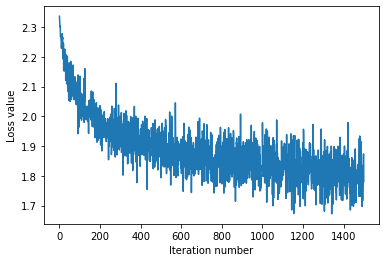

In [10]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [11]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3811428571428571
validation accuracy: 0.398


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [12]:
np.finfo(float).eps

2.220446049250313e-16

learning rate: 1e-09, training loss : 2.246450159524819, training accuracy: 0.18377551020408164, validation accuracy: 0.18
learning rate: 1.8329807108324374e-09, training loss : 2.1558456066257907, training accuracy: 0.18871428571428572, validation accuracy: 0.192
learning rate: 3.359818286283788e-09, training loss : 2.1200654573042166, training accuracy: 0.21610204081632653, validation accuracy: 0.224
learning rate: 6.158482110660254e-09, training loss : 2.09853121893356, training accuracy: 0.26118367346938776, validation accuracy: 0.277
learning rate: 1.1288378916846883e-08, training loss : 1.9894082484253581, training accuracy: 0.2997959183673469, validation accuracy: 0.313
learning rate: 2.0691380811147902e-08, training loss : 1.9240488887294669, training accuracy: 0.3246122448979592, validation accuracy: 0.332
learning rate: 3.792690190732254e-08, training loss : 1.8521618563868776, training accuracy: 0.3526734693877551, validation accuracy: 0.366
learning rate: 6.951927961775605e

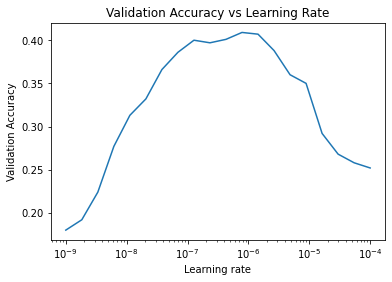

In [14]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
lrs = np.logspace(-9,-4, num = 20)
loss_hists = []
train_accuracy = []
val_accuracy = []

for lr in lrs:
    
    softmax = Softmax(dims=[num_classes, num_features])
    
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr,
                      num_iters=1500, verbose=False)
    loss_hists.append(loss_hist)
    
    y_train_pred = softmax.predict(X_train)
    train_accuracy.append(np.mean(np.equal(y_train,y_train_pred), ))
    
    y_val_pred = softmax.predict(X_val)
    val_accuracy.append(np.mean(np.equal(y_val, y_val_pred)), )
    
    print('learning rate: {}, training loss : {}, training accuracy: {}, validation accuracy: {}'.format(lr, loss_hist[-1], train_accuracy[-1], val_accuracy[-1]))

print('###############################################################################################')
print('best learning rate: {}, best validation accuracy: {}'.format(lrs[np.argmax(val_accuracy)], max(val_accuracy)))
    
plt.semilogx(lrs, val_accuracy)
plt.xlabel("Learning rate")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Learning Rate")
print('###############################################################################################')

softmax = Softmax(dims=[num_classes, num_features])
loss_hist = softmax.train(X_train, y_train, learning_rate=lrs[np.argmax(val_accuracy)], num_iters=1500, verbose=False)
y_test_pred = softmax.predict(X_test)
print('best learning rate: {}, best test error: {}'.format(lrs[np.argmax(val_accuracy)], 1-np.mean(np.equal(y_test, y_test_pred)), ))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


In [ ]:
# softmax.py
import numpy as np

class Softmax(object):

    def __init__(self, dims=[10, 3073]):
        self.init_weights(dims=dims)

    def init_weights(self, dims):
        """
        Initializes the weight matrix of the Softmax classifier.  
        Note that it has shape (C, D) where C is the number of 
        classes and D is the feature size.
        """
        self.W = np.random.normal(size=dims) * 0.0001

    def loss(self, X, y):
        """
        Calculates the softmax loss.

        Inputs have dimension D, there are C classes, and we operate on minibatches
        of N examples.

        Inputs:
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c means
          that X[i] has label c, where 0 <= c < C.

        Returns a tuple of:
        - loss as single float
        """

        # Initialize the loss to zero.
        loss = 0.0

        # ================================================================ #
        # YOUR CODE HERE:
        #   Calculate the normalized softmax loss.  Store it as the variable loss.
        #   (That is, calculate the sum of the losses of all the training 
        #   set margins, and then normalize the loss by the number of 
        #	training examples.)
        # ================================================================ #
        temp = np.zeros((X.shape[0]))
        for i in range(X.shape[0]):
            temp[i] =  self.W[y[i],:].dot(X[i, :].T)
            
        loss = np.sum(np.log(np.sum(np.exp(self.W.dot(X.T)), axis = 0)) - temp)/X.shape[0]

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

        return loss

    def loss_and_grad(self, X, y):
        """
        Same as self.loss(X, y), except that it also returns the gradient.

        Output: grad -- a matrix of the same dimensions as W containing 
            the gradient of the loss with respect to W.
        """

        # Initialize the loss and gradient to zero.
        loss = 0.0
        grad = np.zeros_like(self.W)

        # ================================================================ #
        # YOUR CODE HERE:
        #   Calculate the softmax loss and the gradient. Store the gradient
        #   as the variable grad.
        # ================================================================ #
        temp = np.zeros((X.shape[0]))
        
        for i in range(X.shape[0]):
            temp[i] =  self.W[y[i],:].dot(X[i, :].T)
            
        loss = np.sum(np.log(np.sum(np.exp(self.W.dot(X.T)), axis = 0)) - temp)/X.shape[0]
        
        Z = self.W.dot(X.T)
        expZ = np.exp(Z - np.max(Z))
        A = expZ / expZ.sum(axis=0, keepdims=True)
        
        for i in range(self.W.shape[0]):
            ind1 = np.where(y == i)[0]
            ind2 = np.where(y != i)[0]
            grad[i, :] = -((1 - A[i, ind1]).dot(X[ind1, :]) - A[i, ind2].dot(X[ind2, :]))/X.shape[0]
            
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

        return loss, grad

    def grad_check_sparse(self, X, y, your_grad, num_checks=10, h=1e-5):
        """
        sample a few random elements and only return numerical
        in these dimensions.
        """

        for i in np.arange(num_checks):
            ix = tuple([np.random.randint(m) for m in self.W.shape])

            oldval = self.W[ix]
            self.W[ix] = oldval + h # increment by h
            fxph = self.loss(X, y)
            self.W[ix] = oldval - h # decrement by h
            fxmh = self.loss(X,y) # evaluate f(x - h)
            self.W[ix] = oldval # reset

            grad_numerical = (fxph - fxmh) / (2 * h)
            grad_analytic = your_grad[ix]
            rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
            print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

    def fast_loss_and_grad(self, X, y):
        """
        A vectorized implementation of loss_and_grad. It shares the same
        inputs and ouptuts as loss_and_grad.
        """
        loss = 0.0
        grad = np.zeros(self.W.shape) # initialize the gradient as zero

        # ================================================================ #
        # YOUR CODE HERE:
        #   Calculate the softmax loss and gradient WITHOUT any for loops.
        # ================================================================ #
        Z = self.W.dot(X.T)
        expZ = np.exp(Z - np.max(Z))
        A = expZ / expZ.sum(axis=0, keepdims=True)
        L = np.choose(y, A)
        loss = np.mean(-np.log(L))
        
        Z = self.W.dot(X.T)
        expZ = np.exp(Z - np.max(Z))
        A = expZ / expZ.sum(axis=0, keepdims=True)
        
        targets = np.array(y).reshape(-1)
        one_hot = np.eye(y.max()+1)[targets].T
        grad = -((one_hot*(1 - A)).dot(X) - (np.logical_not(one_hot)*A).dot(X))/X.shape[0]
        

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

        return loss, grad

    def train(self, X, y, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

        self.init_weights(dims=[np.max(y) + 1, X.shape[1]])	# initializes the weights of self.W

        # Run stochastic gradient descent to optimize W
        loss_history = []

        for it in np.arange(num_iters):
            X_batch = None
            y_batch = None

            # ================================================================ #
            # YOUR CODE HERE:
            #   Sample batch_size elements from the training data for use in 
            #	  gradient descent.  After sampling,
            #     - X_batch should have shape: (dim, batch_size)
            #     - y_batch should have shape: (batch_size,)
            #   The indices should be randomly generated to reduce correlations
            #   in the dataset.  Use np.random.choice.  It's okay to sample with
            #   replacement.
            # ================================================================ #
            ind  = np.random.choice(X.shape[0], batch_size)
            X_batch = X[ind, :]
            y_batch = y[ind]
            # ================================================================ #
            # END YOUR CODE HERE
            # ================================================================ #

            # evaluate loss and gradient
            loss, grad = self.fast_loss_and_grad(X_batch, y_batch)
            loss_history.append(loss)

            # ================================================================ #
            # YOUR CODE HERE:
            #   Update the parameters, self.W, with a gradient step 
            # ================================================================ #
            self.W = self.W - learning_rate*grad

            # ================================================================ #
            # END YOUR CODE HERE
            # ================================================================ #

            if verbose and it % 100 == 0:
                print('iteration {} / {}: loss {}'.format(it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Inputs:
        - X: N x D array of training data. Each row is a D-dimensional point.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[1])
        # ================================================================ #
        # YOUR CODE HERE:
        #   Predict the labels given the training data.
        # ================================================================ #
        y_pred = self.W.dot(X.T)
        y_pred = np.argmax(y_pred, axis = 0)
        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

        return y_pred

